## importing the relevant modules for our project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from scipy.sparse import hstack, csr_matrix

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from wordcloud import WordCloud, STOPWORDS 
from textblob import TextBlob
import lightgbm as lgb

%matplotlib inline

In [2]:
# !pip install wordcloud    ## installing wordclaud & lightgbm because this module was installed
# !pip install lightgbm

In [4]:

cd C:\Users\shaqu\Desktop\Data Science Projects\predict the news sentiment ~ ZS\news sentiment\dataset

C:\Users\shaqu\Desktop\Data Science Projects\predict the news sentiment ~ ZS\news sentiment\dataset


In [5]:
# reading the dataset!!

train = pd.read_csv('train_file.csv')
test = pd.read_csv('test_file.csv')


## data exploration!!

In [6]:
train.head()


IDLink                                              Title  \
0  Tr3CMgRv1N   Obama Lays Wreath at Arlington National Cemetery   
1  Wc81vGp8qZ        A Look at the Health of the Chinese Economy   
2  zNGH03CrZH   Nouriel Roubini: Global Economy Not Back to 2008   
3  3sM1H0W8ts                          Finland GDP Expands In Q4   
4  wUbnxgvqaZ  Tourism, govt spending buoys Thai economy in J...   

                                            Headline  \
0  Obama Lays Wreath at Arlington National Cemete...   
1  Tim Haywood, investment director business-unit...   
2  Nouriel Roubini, NYU professor and chairman at...   
3  Finland's economy expanded marginally in the t...   
4  Tourism and public spending continued to boost...   

                                     Source    Topic          PublishDate  \
0                                 USA TODAY    obama  2002-04-02 00:00:00   
1                                 Bloomberg  economy  2008-09-20 00:00:00   
2                                 Bloomberg  economy  2012-01-28 00:00:00   
3                                  RTT News  economy  2015-03-01 00:06:00   
4  The Nation - Thailand&#39;s English news  economy  2015-03-01 00:11:00   

   Facebook  GooglePlus  LinkedIn  SentimentTitle  SentimentHeadline  
0        -1          -1        -1        0.000000          -0.053300  
1        -1          -1        -1        0.208333          -0.156386  
2        -1          -1        -1       -0.425210           0.139754  
3        -1          -1        -1        0.000000           0.026064  
4        -1          -1        -1        0.000000           0.141084

In [7]:
train.shape

(55932, 11)

In [8]:
test.head()

IDLink                                              Title  \
0  tFrqIR6Chj  Sliding Economy: FG fights back with N3trn TSA...   
1  DVAaGErjlF  Microsoft shows how HoloLens can bring distant...   
2  OT9UIZm5M2  Microsoft’s Twitter Robot Praises Hitler, Trum...   
3  lflGp3q2Fj  Flood of Central Bank Moves Can't Get World Ec...   
4  zDYG0SoovZ  USD/JPY: bears lining up on mixed U.S. economy...   

                                            Headline  \
0  With the 2016 budget now passed by the Nationa...   
1  A recent Microsoft Research video shows how th...   
2  * Microsoft teamed with Bing to create TayTwee...   
3  Central bankers have managed to steer the worl...   
4  However, this streak of seven-day gains might ...   

                         Source      Topic          PublishDate  Facebook  \
0                   BusinessDay    economy  2016-03-29 01:41:12         0   
1                    Daily Mail  microsoft  2016-03-29 01:41:27       121   
2                        EURweb  microsoft  2016-03-29 01:47:00        12   
3  Bloomberg via Yahoo! Finance    economy  2016-03-29 02:00:00         0   
4                      FXStreet    economy  2016-03-29 02:01:07         3   

   GooglePlus  LinkedIn  
0           0         1  
1           2        13  
2           1         0  
3           0         3  
4           0         0

In [8]:
test.shape

(37288, 9)

In [9]:
## now focussing on our training dataset first!!

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55932 entries, 0 to 55931
Data columns (total 11 columns):
IDLink               55932 non-null object
Title                55932 non-null object
Headline             55932 non-null object
Source               55757 non-null object
Topic                55932 non-null object
PublishDate          55932 non-null object
Facebook             55932 non-null int64
GooglePlus           55932 non-null int64
LinkedIn             55932 non-null int64
SentimentTitle       55932 non-null float64
SentimentHeadline    55932 non-null float64
dtypes: float64(2), int64(3), object(6)
memory usage: 4.7+ MB


In [11]:
# columns ['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate'] are object type like string and columns ['Facebook', 'GooglePlus', 'LinkedIn',] are numeric type integers and columns ['SentimentTitle',
#        'SentimentHeadline'] are numeric type float !!

In [12]:
train.describe()

Facebook    GooglePlus      LinkedIn  SentimentTitle  \
count  55932.000000  55932.000000  55932.000000    55932.000000   
mean     132.050329      4.551616     14.300132       -0.006318   
std      722.931314     21.137177     76.651420        0.137569   
min       -1.000000     -1.000000     -1.000000       -0.838525   
25%        0.000000      0.000000      0.000000       -0.079057   
50%        6.000000      0.000000      0.000000        0.000000   
75%       37.000000      2.000000      4.000000        0.063969   
max    49211.000000   1267.000000   3716.000000        0.962354   

       SentimentHeadline  
count       55932.000000  
mean           -0.029577  
std             0.143038  
min            -0.755355  
25%            -0.116927  
50%            -0.027277  
75%             0.057354  
max             0.964646

Checking the misssing null, values in the dataset!!

In [10]:
train.isnull().sum()

# source column have 175 records as null!

IDLink                 0
Title                  0
Headline               0
Source               175
Topic                  0
PublishDate            0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64

In [11]:
train['Source'].value_counts()[:10]

# As we can see that most of the source is from bloomberg company then we just fill the null values with bloomberg for easy processing of our data!!

Bloomberg           992
Reuters             763
ABC News            645
New York Times      573
The Guardian        551
Business Insider    550
Forbes              484
Economic Times      461
CNN                 447
WinBeta             445
Name: Source, dtype: int64

In [12]:
train['Source'] = train['Source'].fillna('Bloomberg')

In [13]:
# checkiung the null values again!!
train.isnull().sum()

IDLink               0
Title                0
Headline             0
Source               0
Topic                0
PublishDate          0
Facebook             0
GooglePlus           0
LinkedIn             0
SentimentTitle       0
SentimentHeadline    0
dtype: int64

In [17]:
## text column cleansing!!

# remove the any alpha numerica nd spaces from our dataset to make it clean for our ML modelling!!

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

def clean(text):
  text_token = word_tokenize(text)
  filtered_text = ' '.join([w.lower() for w in text_token if w.lower() not in stop and len(w) > 2])
  filtered_text = filtered_text.replace(r"[^a-zA-Z]+", '')
  text_only = re.sub(r'\b\d+\b', '', filtered_text)
  clean_text = text_only.replace(',', '').replace('.', '').replace(':', '')
  return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shaqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaqu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shaqu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
## checking the null valus for test data
test.isnull().sum()

IDLink           0
Title            0
Headline         0
Source         101
Topic            0
PublishDate      0
Facebook         0
GooglePlus       0
LinkedIn         0
dtype: int64

In [19]:
test['Source'] = test['Source'].fillna('Bloomberg')

# filling the values with the max value of source!

In [20]:
train['Text_Title'] = train['Title'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Title'] = test['Title'] + ' ' + test['Source'] + ' ' + test['Topic']

train['Text_Headline'] = train['Headline'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Headline'] = test['Headline'] + ' ' + test['Source'] + ' ' + test['Topic']

In [21]:
train['Text_Title'][:10]
train['Text_Title'][4]

'Tourism, govt spending buoys Thai economy in January The Nation - Thailand&#39;s English news economy'

In [22]:
train['Text_Title'] = [clean(x) for x in train['Text_Title']]
test['Text_Title'] = [clean(x) for x in test['Text_Title']]

train['Text_Headline'] = [clean(x) for x in train['Text_Headline']]
test['Text_Headline'] = [clean(x) for x in test['Text_Headline']]

In [23]:
train['Text_Title'][:10]

0    obama lays wreath arlington national cemetery ...
1        look health chinese economy bloomberg economy
2    nouriel roubini global economy back  bloomberg...
3                 finland gdp expands rtt news economy
4    tourism govt spending buoys thai economy janua...
5    intellitec solutions host 13th annual spring m...
6                      monday feb  bloomberg palestine
7    obama stars pay musical tribute ray charles co...
8    fire claims -year-old barn hancock county wthr...
9    microsoft new windows targets apple new kerala...
Name: Text_Title, dtype: object

In [25]:
# There is non iisue of whitespace problem!!

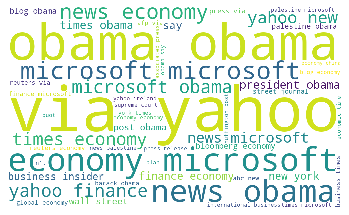

In [24]:
## lets plot the visualization of the text title !!
text = ""
for ind, row in train.iterrows():
    text += row["Text_Title"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=1000, height=600, max_font_size=300, max_words=50).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

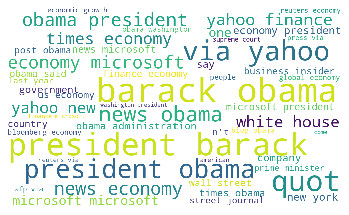

In [27]:
# plot the text headlines!!
text = ""
for ind, row in train.iterrows():
    text += row["Text_Headline"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=1000, height=600, max_font_size=100, max_words=50).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [28]:
## now doing some vectorization method for transforming bour dataset!! for training data set

In [25]:
vectorizer = TfidfVectorizer(use_idf=True)

train_v_Title = vectorizer.fit_transform(train['Text_Title'])
test_v_Title = vectorizer.transform(test['Text_Title'])

vectorizer_ = TfidfVectorizer()

train_v_Headline = vectorizer_.fit_transform(train['Text_Headline'])
test_v_Headline = vectorizer_.transform(test['Text_Headline'])

In [82]:
train_v_Title.shape

(55932, 20)

In [84]:
train_v_Headline.shape

(55932, 20)

In [26]:
# svd = TruncatedSVD(n_components=20)

# train_v_Title = svd.fit_transform(train_v_Title)
# test_v_Title = svd.transform(test_v_Title)

# train_v_Headline = svd.fit_transform(train_v_Headline)
# test_v_Headline = svd.transform(test_v_Headline)

In [30]:
## now doing some vectorization method for transforming our dataset!! for testing data set

Now moving forward to core of our project to calculate the sentiment of our text data!!

In [27]:
train['polarity_title'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_title'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_title'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_title'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [28]:
train['polarity_title']

0        0.00
1        0.00
2        0.00
3        0.00
4        0.00
         ... 
55927    0.00
55928    0.25
55929   -0.70
55930    0.00
55931    0.00
Name: polarity_title, Length: 55932, dtype: float64

In [29]:
train['polarity_headline'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_headline'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_headline'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_headline'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [30]:
train['polarity_headline']

0        0.000000
1        0.100000
2        0.000000
3       -0.166667
4        0.133333
           ...   
55927    0.000000
55928    0.021429
55929    0.088690
55930    0.000000
55931   -0.700000
Name: polarity_headline, Length: 55932, dtype: float64

 now encoding the colum,n topic and source by creating the dummies values!!

In [31]:
encoder = LabelEncoder()

train['Topic'] = encoder.fit_transform(train['Topic'])
test['Topic'] = encoder.transform(test['Topic'])

total = train['Source'].to_list() + test['Source'].to_list()
total = encoder.fit_transform(total)
train['Source'] = encoder.transform(train['Source'])
test['Source'] = encoder.transform(test['Source'])

In [32]:
train['Source']

0        4995
1         518
2         518
3        3621
4        4597
         ... 
55927    5360
55928    2500
55929    2010
55930    4185
55931    5382
Name: Source, Length: 55932, dtype: int32

In [33]:
test['Source']

0         659
1        1146
2        1350
3         524
4        1556
         ... 
37283    2767
37284    4121
37285    1132
37286     169
37287    1359
Name: Source, Length: 37288, dtype: int32

In [34]:
# day type monday to sunday from datetime!!

train_weekday = []
test_weekday = []

for i in train['PublishDate']:
    train_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))
    
for i in test['PublishDate']:
    test_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))

train['weekday'] = train_weekday
test['weekday'] = test_weekday


# convert weekday to 1-7 of train data

train['weekday'] = train['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})


In [35]:
# convert weekday to 1-7 of test data
test['weekday'] = test['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})

In [36]:
train["hour"] = train["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])
test["hour"] = test["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])

Text(0, 0.5, 'SentimentTitle')

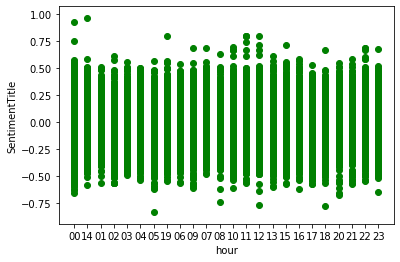

In [37]:

# plotting of the hour vs sentiminet title 
plt.scatter(train['hour'], train['SentimentTitle'], color= 'green')
plt.xlabel('hour')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

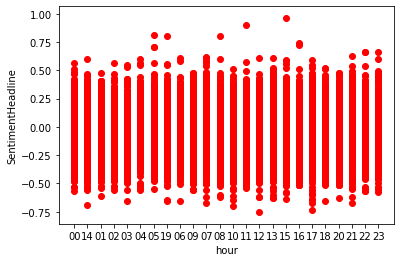

In [40]:
# distribution plot for hour vs sentimental headlines

plt.scatter(train['hour'], train['SentimentHeadline'], color='red')
plt.xlabel('hour')
plt.ylabel('SentimentHeadline')

Text(0, 0.5, 'SentimentTitle')

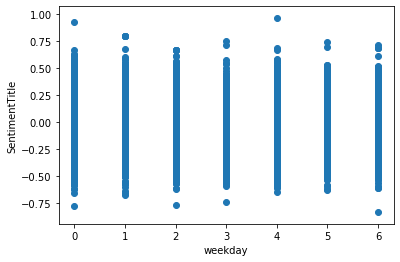

In [41]:
# weekday distribution for weekdays and setimental Title!!

plt.scatter(train['weekday'], train['SentimentTitle'])
plt.xlabel('weekday')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

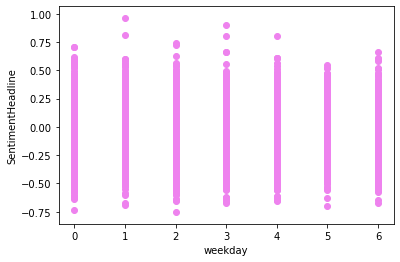

In [42]:
# weekday distribution for weekdays and setimental Headlines!!


plt.scatter(train['weekday'], train['SentimentHeadline'], color= 'violet')
plt.xlabel('weekday')
plt.ylabel('SentimentHeadline')

In [47]:
train['SentimentHeadline']

0       -0.053300
1       -0.156386
2        0.139754
3        0.026064
4        0.141084
           ...   
55927   -0.055902
55928    0.056110
55929    0.114820
55930   -0.028296
55931    0.184444
Name: SentimentHeadline, Length: 55932, dtype: float64

In [43]:
# figuuring out the number of words in the title!!

# Number of words in the Title 
train["num_words_title"] = train["Text_Title"].apply(lambda x: len(str(x).split()))
test["num_words_title"] = test["Text_Title"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Title 
train["num_unique_words_title"] = train["Text_Title"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_title"] = test["Text_Title"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Title 
train["num_chars_title"] = train["Text_Title"].apply(lambda x: len(str(x)))
test["num_chars_title"] = test["Text_Title"].apply(lambda x: len(str(x)))

# Average length of the words in the Title 
train["mean_word_len_title"] = train["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_title"] = test["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [44]:
# figuuring out the number of words in the title!!

train["num_words_headline"] = train["Text_Headline"].apply(lambda x: len(str(x).split()))
test["num_words_headline"] = test["Text_Headline"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Headline 
train["num_unique_words_headline"] = train["Text_Headline"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_headline"] = test["Text_Headline"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Headline 
train["num_chars_headline"] = train["Text_Headline"].apply(lambda x: len(str(x)))
test["num_chars_headline"] = test["Text_Headline"].apply(lambda x: len(str(x)))

# Average length of the words in the Headline 
train["mean_word_len_headline"] = train["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_headline"] = test["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [45]:
## now standardization with scalar module!!

scaler = StandardScaler()

cols = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_title', 'num_unique_words_title', 'num_chars_title', 'mean_word_len_title',
        'num_words_headline', 'num_unique_words_headline', 'num_chars_headline', 'mean_word_len_headline', 'hour', 'weekday']

for col in cols:
  train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
  test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [46]:

# check the columns titles and headlines 

cols_title = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_title', 'num_unique_words_title', 'num_chars_title', 'mean_word_len_title', 'polarity_title', 'subjectivity_title', 'hour', 'weekday']
train_X1 = train[cols_title]
test_X1 = test[cols_title]

cols_headline = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_headline', 'num_unique_words_headline', 'num_chars_headline', 'mean_word_len_headline', 'polarity_headline', 'subjectivity_headline', 'hour', 'weekday']
train_X2 = train[cols_headline]
test_X2 = test[cols_headline]


In [47]:
train_X1.head()

Source     Topic  Facebook  GooglePlus  LinkedIn  num_words_title  \
0  1.257700  0.841443 -0.184044   -0.262649 -0.199608        -0.259144   
1 -1.314091 -1.108773 -0.184044   -0.262649 -0.199608        -1.668699   
2 -1.314091 -1.108773 -0.184044   -0.262649 -0.199608        -1.198848   
3  0.468412 -1.108773 -0.184044   -0.262649 -0.199608        -1.668699   
4  1.029071 -1.108773 -0.184044   -0.262649 -0.199608         1.150411   

   num_unique_words_title  num_chars_title  mean_word_len_title  \
0               -0.304659        -0.572668            -0.612899   
1               -1.721681        -1.629548             0.274497   
2               -1.249340        -1.035053             0.328828   
3               -1.249340        -2.224043            -1.436911   
4                1.112364         1.012652            -0.295972   

   polarity_title  subjectivity_title      hour   weekday  
0             0.0                 0.0 -1.699073 -0.795924  
1             0.0                 0.0 -1.699073  1.338369  
2             0.0                 0.0 -1.699073  1.338369  
3             0.0                 0.0 -1.699073  1.871942  
4             0.0                 0.0 -1.699073  1.871942

In [48]:
train_X2.head()

Source     Topic  Facebook  GooglePlus  LinkedIn  num_words_headline  \
0  1.257700  0.841443 -0.184044   -0.262649 -0.199608           -0.285943   
1 -1.314091 -1.108773 -0.184044   -0.262649 -0.199608           -0.285943   
2 -1.314091 -1.108773 -0.184044   -0.262649 -0.199608           -0.413305   
3  0.468412 -1.108773 -0.184044   -0.262649 -0.199608            0.096143   
4  1.029071 -1.108773 -0.184044   -0.262649 -0.199608            0.223505   

   num_unique_words_headline  num_chars_headline  mean_word_len_headline  \
0                  -0.526753           -0.490533               -1.058531   
1                  -0.232503           -0.317671               -0.175891   
2                  -0.673878           -0.300385                0.618485   
3                   0.061747            0.304632                0.843558   
4                   0.208872            0.391063                0.618485   

   polarity_headline  subjectivity_headline      hour   weekday  
0           0.000000               0.000000 -1.699073 -0.795924  
1           0.100000               0.200000 -1.699073  1.338369  
2           0.000000               0.041667 -1.699073  1.338369  
3          -0.166667               0.166667 -1.699073  1.871942  
4           0.133333               0.380556 -1.699073  1.871942

In [49]:
test_X1.head()

Source     Topic  Facebook  GooglePlus  LinkedIn  num_words_title  \
0 -1.233094 -1.108773 -0.182661   -0.215339 -0.173516        -0.259144   
1 -0.953339 -0.133665 -0.015286   -0.120718 -0.016962         0.210707   
2 -0.836153 -0.133665 -0.166062   -0.168028 -0.186562         0.210707   
3 -1.310644 -1.108773 -0.182661   -0.215339 -0.147424         2.090114   
4 -0.717817 -1.108773 -0.178511   -0.215339 -0.186562        -0.259144   

   num_unique_words_title  num_chars_title  mean_word_len_title  \
0               -0.304659        -0.440558            -0.359357   
1                0.167682         0.352102             0.084341   
2                0.167682         0.418157             0.312529   
3                2.057046         1.078707            -1.382580   
4               -0.304659        -0.506613            -0.486128   

   polarity_title  subjectivity_title      hour   weekday  
0             0.0                0.00 -1.555397 -0.795924  
1            -0.1                0.35 -1.555397 -0.795924  
2             0.0                0.00 -1.555397 -0.795924  
3             0.0                0.25 -1.411721 -0.795924  
4             0.0                0.25 -1.411721 -0.795924

In [50]:
test_X2.head()

Source     Topic  Facebook  GooglePlus  LinkedIn  num_words_headline  \
0 -1.233094 -1.108773 -0.182661   -0.215339 -0.173516           -0.668030   
1 -0.953339 -0.133665 -0.015286   -0.120718 -0.016962           -0.413305   
2 -0.836153 -0.133665 -0.166062   -0.168028 -0.186562            2.133938   
3 -1.310644 -1.108773 -0.182661   -0.215339 -0.147424            0.096143   
4 -0.717817 -1.108773 -0.178511   -0.215339 -0.186562           -0.413305   

   num_unique_words_headline  num_chars_headline  mean_word_len_headline  \
0                  -0.526753           -0.490533                1.047196   
1                  -0.379628           -0.404102               -0.037978   
2                   1.974371            2.517265                0.743526   
3                   0.208872           -0.110237               -0.957027   
4                  -0.379628           -0.542392               -0.694442   

   polarity_headline  subjectivity_headline      hour   weekday  
0           0.000000               0.000000 -1.555397 -0.795924  
1           0.000000               0.250000 -1.555397 -0.795924  
2          -0.157407               0.251852 -1.555397 -0.795924  
3           0.087500               0.272917 -1.411721 -0.795924  
4           0.000000               0.000000 -1.411721 -0.795924

In [56]:
train.columns

Index(['IDLink', 'Title', 'Headline', 'Source', 'Topic', 'PublishDate',
       'Facebook', 'GooglePlus', 'LinkedIn', 'SentimentTitle',
       'SentimentHeadline', 'Text_Title', 'Text_Headline', 'polarity_title',
       'subjectivity_title', 'polarity_headline', 'subjectivity_headline',
       'weekday', 'hour', 'num_words_title', 'num_unique_words_title',
       'num_chars_title', 'mean_word_len_title', 'num_words_headline',
       'num_unique_words_headline', 'num_chars_headline',
       'mean_word_len_headline'],
      dtype='object')

In [57]:
# checking the shape of the data

print(train_X1.shape, 'train X1')
print(test_X1.shape, 'test X1')

(55932, 13) train X1
(37288, 13) test X1


In [58]:
print(train_X2.shape, 'train X2')
print(test_X2.shape, 'test X2')

(55932, 13) train X2
(37288, 13) test X2


In [64]:

print(np.shape(train_v_Title))
print(np.shape(test_v_Title))

(55932, 20)
(37288, 20)


In [65]:
print(np.shape(train_v_Headline))
print(np.shape(test_v_Headline))

(55932, 20)
(37288, 20)


In [59]:
print(np.shape(train_v_Title))
print(np.shape(test_v_Title))

(55932, 20)
(37288, 20)


In [61]:
print(np.shape(train_v_Headline))
print(np.shape(test_v_Headline))

(55932, 20)
(37288, 20)


reducing the dimesnion for better performance of the model using SVD!!

In [63]:
print(train_v_Headline, 'train headlines')
print(test_v_Headline, 'test  headlines')

[[ 0.16775825 -0.11412548 -0.04822087 ... -0.00986373 -0.01220966
  -0.02261364]
 [ 0.078058    0.07474753  0.11667698 ...  0.04775589 -0.05251913
  -0.09417374]
 [ 0.0533445   0.05564995  0.10977539 ...  0.0646559  -0.00551403
  -0.04585838]
 ...
 [ 0.1630509  -0.09041928 -0.03639916 ...  0.02606334 -0.05286184
  -0.00654206]
 [ 0.07765037  0.18697134 -0.14515641 ... -0.0324557  -0.00185224
  -0.01104474]
 [ 0.1170965   0.04986726  0.13595587 ...  0.07324378 -0.0077704
  -0.02188705]] train headlines
[[ 0.08542381  0.00946836  0.06325832 ... -0.02996335 -0.02102944
   0.01318694]
 [ 0.09013356  0.16647582 -0.12805879 ... -0.00569838 -0.02772593
  -0.00278818]
 [ 0.04638863  0.10680215 -0.08848141 ... -0.0041639  -0.01038824
  -0.00113923]
 ...
 [ 0.0451431   0.01544674  0.01889963 ... -0.00841987 -0.01385428
   0.01302112]
 [ 0.03321775  0.01313172  0.00825601 ...  0.01274547  0.02344735
  -0.03616345]
 [ 0.07408856  0.13338602 -0.10063309 ... -0.02347683  0.03425783
  -0.00212084]] t

In [66]:

train_X_Title = hstack([train_v_Title, csr_matrix(train_X1.values)])
test_X_Title = hstack([test_v_Title, csr_matrix(test_X1.values)])
y1 = train['SentimentTitle']

train_X_Headline = hstack([train_v_Headline, csr_matrix(train_X2.values)])
test_X_Headline = hstack([test_v_Headline, csr_matrix(test_X2.values)])
y2 = train['SentimentHeadline']

In [67]:
print(train_X_Title.shape,'train x title')
print(test_X_Title.shape,'test x title')
print(train_X_Headline.shape,'train x Headline')
print(test_X_Headline.shape,'test x Headline')

(55932, 33) train x title
(37288, 33) test x title
(55932, 33) train x Headline
(37288, 33) test x Headline


In [68]:
np.shape(train_X_Title)

(55932, 33)

In [69]:
train_X_Title = hstack([train_v_Title, csr_matrix(train_X1.values)])
test_X_Title = hstack([test_v_Title, csr_matrix(test_X1.values)])
y1 = train['SentimentTitle']

train_X_Headline = hstack([train_v_Headline, csr_matrix(train_X2.values)])
test_X_Headline = hstack([test_v_Headline, csr_matrix(test_X2.values)])
y2 = train['SentimentHeadline']

In [70]:
np.shape(train_X_Title)
# np.shape(test_v_Title)

(55932, 33)

## Selecting Machine learning model for best MAE results!!

In [71]:
# 1) select support vector m,achine model now with c= 0.2!

X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)

MAE: 0.9055280809735686


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [72]:
# 1) select support vector m,achine model now with c= 3!



X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.3)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)

MAE: 0.8946623612719957


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [69]:

# X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

# # clf3 = LinearSVR(C=0.9)
# # clf3.fit(X_train, y_train)

# # y_pred3 = clf3.predict(X_test)
# # mae3 = mean_absolute_error(y_pred3, y_test)
# # print('MAE:', 1 - mae3)

In [70]:
## so our result with c= 0.9 in linear support vector regression is highest. so that we will use c= 0.9!!

## now checking the MAE( mean absolute error)

In [73]:
print('Leaderborad score=', max(0, 1 - ((0.4 * mae1) + (0.6 * mae2))))

Leaderborad score= 0.8990086491526249


Now make prediction with test data!

In [74]:
title = clf1.predict(test_X_Title)
headline = clf2.predict(test_X_Headline)

In [88]:
df = pd.DataFrame()
test_id = test['IDLink']
df['IDLink'] = test_id
df['SentimentTitle'] = title
df['SentimentHeadline'] = headline
df.to_csv('sample_submissions.csv', index = False)

In [79]:
y_pred1.shape

(11187,)

####  conclusion
I have created the news sentiment analysis of the dataset provided using different metrics, and converted the sentiment title and headline into poloarity of the sentiments.. the more posive a setiment is the more it's positive and neagtive value of polarity is negative sentiments!!

After analysing and using linear SVM modelling we reduced the MAE to 89.9 % with c= 0.2

This model can be trained with other different news sentiment analysis for further use aswelll!!

or can be transformed easily to use video and comments sentiment analysis of any ecommerce websites aswell!!


